In [ ]:
 # !pip install skforecast

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# regression 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline

# metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# forecasting
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [ ]:
url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o_exog.csv'
df = pd.read_csv(url, sep=',')
display(df)




,fecha,y,exog_1,exog_2
0,1992-04-01,0.379808,0.958792,1.166029
1,1992-05-01,0.361801,0.951993,1.117859
2,1992-06-01,0.410534,0.952955,1.067942
3,1992-07-01,0.483389,0.958078,1.097376
4,1992-08-01,0.475463,0.956370,1.122199
...,...,...,...,...
190,2008-02-01,0.761822,1.515840,1.786373
191,2008-03-01,0.649435,1.506258,1.694264
192,2008-04-01,0.827887,1.505253,1.627135
193,2008-05-01,0.816255,1.491464,1.555068


# **Split**

In [ ]:
steps = 36

# train
df_train = df[:-steps]
train_x = df_train[['exog_1', 'exog_2']]
train_y = df_train['y']

# test
df_test  = df[-steps:]
test_x = df_test[['exog_1', 'exog_2']]
test_y = df_test['y']


# plot
fig, ax=plt.subplots(figsize=(12, 6))
train_y.plot(ax=ax, label='train')
test_y.plot(ax=ax, label='test')
ax.legend();
plt.show()

# **Pipeline and Forecasting**

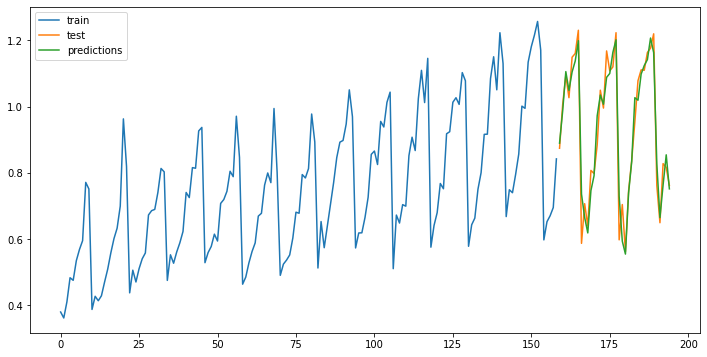

In [ ]:
# pipeline
# make_pipeline genera automaticamente gli id "standardscaler" e "ridge"
test_pipe = make_pipeline(StandardScaler(), Ridge())




# forecasting
test_forecaster = ForecasterAutoreg(
                    regressor = test_pipe,
                    lags = 10
                  )

test_forecaster.fit(y=train_y, exog=train_x)




# prediction
test_pred = test_forecaster.predict(steps=steps, exog=test_x)





# plot
fig, ax=plt.subplots(figsize=(12, 6))
train_y.plot(ax=ax, label='train')
test_y.plot(ax=ax, label='test')
test_pred.plot(ax=ax, label='predictions')
ax.legend();
plt.show()

In [ ]:

mse_all = mean_squared_error(test_y, test_pred)
r2_all  = r2_score(test_y, test_pred)
print(" MSE:", mse_all, "  R2:", r2_all) 


 MSE: 0.0028713881069742254   R2: 0.9327150360916101


# **Grid Search**

In [ ]:
param_grid = {'ridge__alpha': [0.0001, 0.001, 0.01, 0.1, 1., 10.]}


lags_grid = [5, 24, [1, 2, 3, 23, 24]]

test_grid = grid_search_forecaster(
                        forecaster  = test_forecaster,
                        y           = train_y, # x
                        exog        = train_x, # y
                        param_grid  = param_grid,
                        lags_grid   = lags_grid,
                        steps       = steps,
                        metric      = 'mean_absolute_error',
                        refit       = False,
                        initial_train_size = len(test_y),
                        return_best = True,
                        verbose     = False
                  )


# **Save and load model**

In [ ]:
# pipeline
pipe = make_pipeline(StandardScaler(), Ridge(alpha=0.0001))




# forecasting
forecaster = ForecasterAutoreg(
                    regressor = pipe,
                    lags = 5
                  )

forecaster.fit(y=train_y, exog=train_x)


In [ ]:
from skforecast.utils import save_forecaster

save_forecaster(forecaster, file_name='forecaster.py', verbose=False)




In [ ]:
from skforecast.utils import load_forecaster


forecaster_loaded = load_forecaster('forecaster.py')


# prediction
pred = forecaster_loaded.predict(steps=steps, exog=test_x)





# plot
fig, ax=plt.subplots(figsize=(16, 12))
test_y.plot(ax=ax, label='test')
pred.plot(ax=ax, label='predictions',   style='.', markersize=13)
ax.legend();
plt.show()
